In [12]:
!unzip aclImdb.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: aclImdb/train/pos/9260_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._9260_7.txt  
  inflating: aclImdb/train/pos/1599_7.txt  
  inflating: __MACOSX/aclImdb/train/pos/._1599_7.txt  
  inflating: aclImdb/train/pos/2174_8.txt  
  inflating: __MACOSX/aclImdb/train/pos/._2174_8.txt  
  inflating: aclImdb/train/pos/2309_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._2309_9.txt  
  inflating: aclImdb/train/pos/12034_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._12034_10.txt  
  inflating: aclImdb/train/pos/11703_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._11703_9.txt  
  inflating: aclImdb/train/pos/5619_9.txt  
  inflating: __MACOSX/aclImdb/train/pos/._5619_9.txt  
  inflating: aclImdb/train/pos/2928_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._2928_10.txt  
  inflating: aclImdb/train/pos/7096_10.txt  
  inflating: __MACOSX/aclImdb/train/pos/._7096_10.txt  
  inflating: aclImdb/train/pos/793_9.txt  
  inflating: __MACOS

In [13]:
import os

In [15]:
imdb_dir ='./aclImdb'
train_dir = os.path.join(imdb_dir, 'train')


In [16]:
labels = []
texts = []


In [17]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname  in os.listdir(dir_name):
        if fname[-4:] == '.txt' :
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
           
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else :
                labels.append(1)

# 텍스트를 벡터로 만들고 훈련세트와 검증세트로 나눔
## 훈련데이터를 200개로 제한 - 200개 샘플 학습후 영화 리뷰를 분류

In [ ]:
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [55]:
maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000


In [56]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [57]:
word_index =  tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 88582 unique tokens.


In [58]:
data = pad_sequences(sequences, maxlen=maxlen)

In [59]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [60]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


In [61]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val =  data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

## Downloading the GloVe Word Embeddings

In [62]:
!unzip glove.6B.100d.txt.zip

Archive:  glove.6B.100d.txt.zip
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [63]:
glove_dir = './'

In [64]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s unique tokens.' % len(embeddings_index))

Found 400000 unique tokens.


## Preprocessing the Embeddings

In [65]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


- model definition


In [66]:
from keras.models import Sequential

In [67]:
from keras.layers import Embedding, Flatten, Dense


In [68]:
model = Sequential()

In [69]:
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))



In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


- Loading pertained word embeddings into the Embedding layer

In [71]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False #추가적으로 Embedding층을 동결

In [72]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])


In [73]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/10
7/7 [==============================] - 2s 153ms/step - loss: 1.3217 - acc: 0.5350 - val_loss: 0.7277 - val_acc: 0.4956
Epoch 2/10
7/7 [==============================] - 1s 223ms/step - loss: 0.5503 - acc: 0.7450 - val_loss: 1.0023 - val_acc: 0.5038
Epoch 3/10
7/7 [==============================] - 1s 225ms/step - loss: 0.5463 - acc: 0.7200 - val_loss: 0.7183 - val_acc: 0.5039
Epoch 4/10
7/7 [==============================] - 1s 226ms/step - loss: 0.3282 - acc: 0.9350 - val_loss: 0.8062 - val_acc: 0.4979
Epoch 5/10
7/7 [==============================] - 1s 169ms/step - loss: 0.3017 - acc: 0.9300 - val_loss: 0.7558 - val_acc: 0.5001
Epoch 6/10
7/7 [==============================] - 1s 125ms/step - loss: 0.1987 - acc: 0.9600 - val_loss: 0.8858 - val_acc: 0.4984
Epoch 7/10
7/7 [==============================] - 1s 103ms/step - loss: 0.1285 - acc: 0.9950 - val_loss: 0.7895 - val_acc: 0.4994
Epoch 8/10
7/7 [==============================] - 1s 104ms/step - loss: 0.1643 - acc: 0.94

In [74]:
model.save_weights('pre_trained_globe_model.h5')

- Plotting the Results

In [75]:
import matplotlib.pyplot as plt


In [76]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [77]:
epochs = range(1, len(acc) + 1)


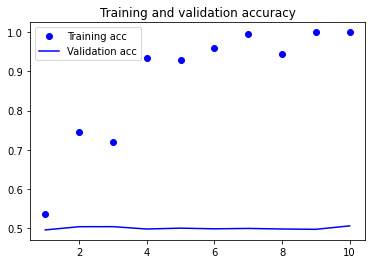

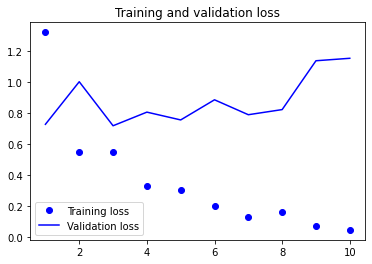

In [81]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()